In [114]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns

"""sns.set()
sns.countplot(train_data["Comment"])
plt.show()"""

'sns.set()\nsns.countplot(train_data["Comment"])\nplt.show()'

In [115]:
test_data = pd.read_csv("./input/test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("./input/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("./input/val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")

In [116]:
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


<Axes: xlabel='length', ylabel='Density'>

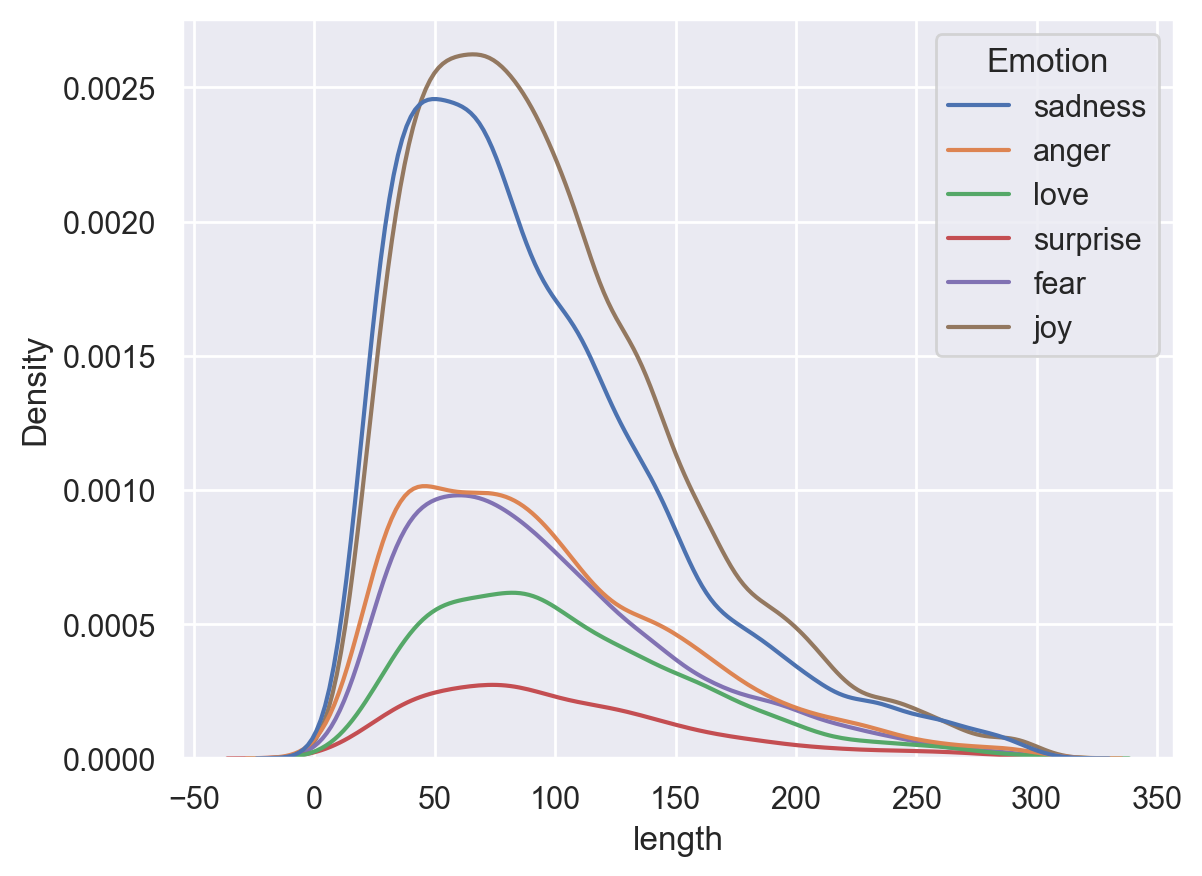

In [117]:
train_data["length"] = [len(i) for i in train_data["Comment"]]
sns.kdeplot(x=train_data["length"], hue=train_data["Emotion"])

In [118]:
lb = LabelEncoder()
train_data["Emotion"] = lb.fit_transform(train_data["Emotion"])
test_data["Emotion"] = lb.fit_transform(test_data["Emotion"])
validation_data["Emotion"] = lb.fit_transform(validation_data["Emotion"])

In [119]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [120]:
vocab_size = 10000
train_data["length"].max()
train_data["length"].min()
len_sentence = 150
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [121]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [122]:
def text_prepare(data, column):
    print(data.shape)
    stemmer = PorterStemmer()
    corpus = []
    
    for text in data[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        
        text = text.lower()
        text = text.split()
        
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    embeddec_doc = pad_sequences(sequences=one_hot_word,
                              maxlen=len_sentence,
                              padding="pre")
    print(data.shape)
    return embeddec_doc

In [123]:
x_train = text_prepare(train_data, "Comment")
x_validate = text_prepare(validation_data, "Comment")
x_test = text_prepare(test_data, "Comment")

(16000, 3)
(16000, 3)
(2000, 2)
(2000, 2)
(2000, 2)
(2000, 2)


In [124]:
y_train=train_data["Emotion"]
y_validate=validation_data["Emotion"]
y_test=test_data["Emotion"]

In [125]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train = np.array(y_train)
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()

In [126]:
y_test = np.array(y_test)
y_validate = np.array(y_validate)

y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()
y_validate = enc.fit_transform(y_validate.reshape(-1,1)).toarray()

In [127]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

In [128]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=150, input_length=len_sentence))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(6, activation="softmax"))

model.compile(optimizer="Adam", loss = "categorical_crossentropy", metrics=["accuracy"])

In [129]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [130]:
history = model.fit(x_train, y_train, epochs = 25, batch_size = 64, validation_data=(x_validate, y_validate))

Epoch 1/25
250/250 [==============================] - 20s 74ms/step - loss: 1.4360 - accuracy: 0.4392 - val_loss: 1.1939 - val_accuracy: 0.5810
Epoch 2/25
 79/250 [========>.....................] - ETA: 12s - loss: 0.8956 - accuracy: 0.6869

KeyboardInterrupt: 